# Проект "поиск токсичных комментариев"

Построоить модель, классифицирующую комментарии на позитивные и негативные на основании набора данных с разметкой о токсичности правок (*F1* не меньше 0.75).

## Подготовка

Сделаем все необходимые импорты:

In [26]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 366 kB 1.5 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [27]:
import pandas as pd
import numpy as np

import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score


import matplotlib.pyplot as plt
from wordcloud import WordCloud

RANDOM_STATE = 42
from warnings import filterwarnings
filterwarnings('ignore')

<h3>Изучение данных</h3>

<h3>Загрузка и изучение данных</h3>

Откроем и изучим файл:

In [2]:
comments = pd.read_csv('/datasets/toxic_comments.csv')
display(comments.head(5))
comments.info()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Можно видеть, что в файле содержатся записи на английском языке, а также столбец toxic - целевой признак (является комментарий токсичным или нет). Убедимся, что столбец toxic содержит только 2 значения: 0 и 1, а также определим, присутствует ли дисбаланс классов

In [3]:
print('Уникальные значения в столбце toxic: ',comments['toxic'].unique())

Уникальные значения в столбце toxic:  [0 1]


In [4]:
print('Доля токсичных комментариев: ',comments['toxic'].mean())

Доля токсичных комментариев:  0.10167887648758234


Наблюдается явный дисбаланс классов. Это необходимо будет учесть при обучении моделей

Построим облако слов для положительных и токсичных комментариев и посмотрим, какие слова употребляются чаще в том и другом случае:

In [28]:
wc = WordCloud(background_color="white", max_words=10000)

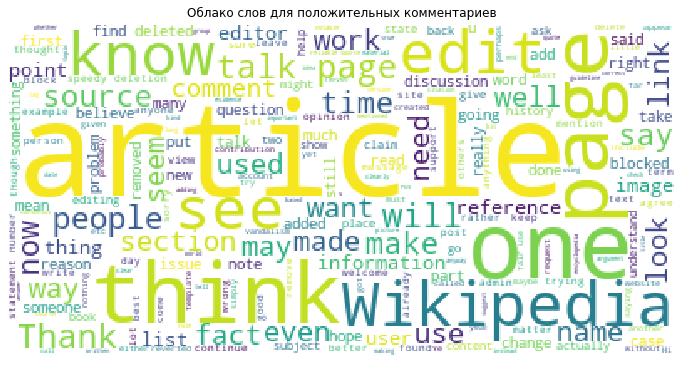

In [31]:
pos_comments = comments.query('toxic == 0')
neg_comments = comments.query('toxic == 1')

fig = plt.figure(1, figsize=(12, 8))
plt.title('Облако слов для положительных комментариев')
plt.axis('off')
wc.generate(" ".join(pos_comments["text"]))
plt.imshow(wc)

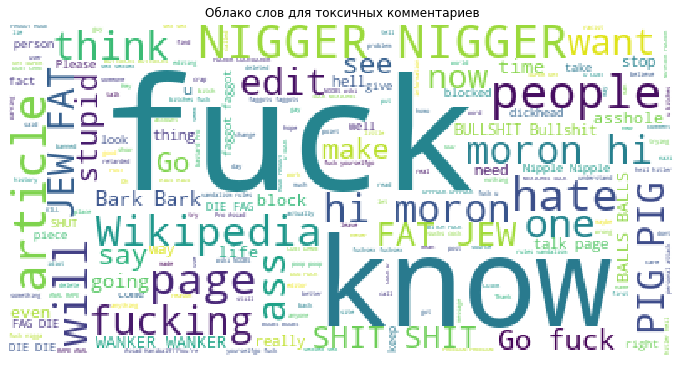

In [32]:
fig = plt.figure(1, figsize=(12, 8))
plt.title('Облако слов для токсичных комментариев')
plt.axis('off')
wc.generate(" ".join(neg_comments["text"]))
plt.imshow(wc)

<b>Вывод</b><br>
Очевидно, что люди, пишущие положительные комментарии любят  ссылаться на статьи, мысли, знания, имена, а также часто благодарят. Люди, пишущие токсичные комментарии часто более эмоциональны, причем эмоции эти негативные. Они используют в своей речи нелитературные слова, оскорбления (в том числе абсолютно неполиткорректные), однако они часто что-то знают и примерно также любят википедию, как и те, кто пишет положительные комментарии. 

<h3>Подготовка данных: очистка, лемматизация и векторизация </h3>

Создадим функции для очистки текста от ненужных символов и лемматизции его

In [5]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]',' ',text)
    return ' '.join(text.split())

Очистим и лемматизируем комментарии

In [6]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [7]:
def get_wordnet_pos(word):
    """Определение POS-тега для WordNetLemmatizer"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_sentence(text):
    return [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]


lemmatizer = WordNetLemmatizer()

comments['lemm_text'] = comments['text'].copy()
comments['lemm_text']  = comments['lemm_text'] .apply(clear_text)
comments['lemm_text']  = comments['lemm_text'] .apply(lemmatize_sentence)
print('Лемматизация прошла успешно')

Лемматизация прошла успешно


Разделим выборку на обучающую и тестовую

In [8]:
target = comments['toxic']
features = comments['lemm_text']
features_train, features_test, tg_train, tg_test = train_test_split(features,target, test_size = 0.25, random_state=RANDOM_STATE, stratify = target)

In [9]:
print('shape train - ', features_train.shape)
print('shape test - ', features_test.shape)

shape train -  (119678,)
shape test -  (39893,)


Текст очищен от ненужных символов и лемматизирован. Создадим счетчик TF-IDF и корпус слов (для обучающей и тестовой выборки)

Загрузим список стоп-слов:

In [10]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
train_index = features_train.index
test_index = features_test.index

count_tf_idf = TfidfVectorizer(preprocessor=' '.join,stop_words = stopwords, min_df=0.0001, lowercase = True)
#создадим корпус для обучающей выборки
corp = features_train.values
ft_train =  count_tf_idf.fit_transform(corp)
print('Размер обучающий: ',ft_train.shape)



Размер обучающий:  (119678, 16510)


In [12]:
#создадим корпус для тестовой выборки
corp = features_test.values
ft_test = count_tf_idf.transform(corp)
print('Размер тестовый:',ft_test.shape)

Размер тестовый: (39893, 16510)


<b>Вывод</b><br>
Данные подготовлены к обучению. Количество признаков - 16510

## Обучение

Создадим датасет для сравнения моделей

In [13]:
def add_to_model_types_compare(mtc,mod_name,best_params,best_scores,test_score):
    mtc = mtc.append({'model_name':mod_name,'best_params':best_params,'train_score':best_scores,'test_score':test_score},ignore_index = True)
    display(mtc)
    return mtc
model_types_compare = pd.DataFrame()

Напишем функцию для подбора гиперпараметров:

In [14]:
def find_best_model(model,params,feat_train,feat_test,targ_train,targ_test,mtc,mod_name,cat_features, model_lib):
    grd = GridSearchCV(estimator = model, param_grid = params, scoring = 'f1', 
                               cv = 2, verbose= 5,n_jobs = -1)
    if model_lib == 'LGBM':
        grd.fit(feat_train, targ_train,categorical_feature = 'auto') 
    elif model_lib == 'CB' and len(cat_features)> 0:
        grd.fit(feat_train, targ_train,cat_features = cat_features)   
    else:
        grd.fit(feat_train, targ_train)
    bp = grd.best_params_
    #bs = grd.best_score_
    train_sc = f1_score(targ_train,grd.predict(feat_train))
    est = grd.best_estimator_
    test_sc = f1_score(targ_test,grd.predict(feat_test))
    mtc = add_to_model_types_compare(mtc,mod_name,bp,train_sc,test_sc)
    return mtc,est

<h3>DummyClassifier</h3>

In [15]:
dummy_clf = DummyClassifier(strategy="constant", 
                            random_state=RANDOM_STATE,
                          constant=[1])
dummy_clf.fit(ft_train, tg_train)
pred_train = dummy_clf.predict(ft_train)
f1_train = f1_score(tg_train,pred_train)
pred_test = dummy_clf.predict(ft_test)
f1_test = f1_score(tg_test,pred_test)
model_types_compare = add_to_model_types_compare(model_types_compare,'DummyClassifier','strategy: constant',f1_train,f1_test)

,best_params,model_name,test_score,train_score
0,strategy: constant,DummyClassifier,0.184578,0.184593


Для DummyClassifier значение при constant = 1 меры 1 f1 = 0.18 (очевидно из-за явного дисбаланса классов), при значении constant = 0 (то же что и при strategy = 'most_frequent' или strategy = 'prior') значение f1=0 (очевидно, из-за квадратичной зависимости от True Positive, которых в данном случае 0)

<h3>Логистическая регрессия</h3>

In [16]:
lgr = LogisticRegression()
params = {'fit_intercept':[True,False], 'C':[4.3,4.35,4.4,4.45,4.5],'class_weight':['balanced'],'random_state':[RANDOM_STATE]}
model_types_compare,best_lgr = find_best_model(lgr,params,ft_train,ft_test,tg_train,tg_test,model_types_compare,'LogisticRegression balanced',[], 'SL')

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] C=4.3, class_weight=balanced, fit_intercept=True, random_state=42 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=4.3, class_weight=balanced, fit_intercept=True, random_state=42, score=0.740, total=  14.3s
[CV] C=4.3, class_weight=balanced, fit_intercept=True, random_state=42 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.3s remaining:    0.0s


[CV]  C=4.3, class_weight=balanced, fit_intercept=True, random_state=42, score=0.731, total=  15.4s
[CV] C=4.3, class_weight=balanced, fit_intercept=False, random_state=42 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   29.7s remaining:    0.0s


[CV]  C=4.3, class_weight=balanced, fit_intercept=False, random_state=42, score=0.695, total=  16.0s
[CV] C=4.3, class_weight=balanced, fit_intercept=False, random_state=42 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   45.7s remaining:    0.0s


[CV]  C=4.3, class_weight=balanced, fit_intercept=False, random_state=42, score=0.685, total=  15.3s
[CV] C=4.35, class_weight=balanced, fit_intercept=True, random_state=42 


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.0min remaining:    0.0s


[CV]  C=4.35, class_weight=balanced, fit_intercept=True, random_state=42, score=0.739, total=  15.8s
[CV] C=4.35, class_weight=balanced, fit_intercept=True, random_state=42 
[CV]  C=4.35, class_weight=balanced, fit_intercept=True, random_state=42, score=0.731, total=  15.3s
[CV] C=4.35, class_weight=balanced, fit_intercept=False, random_state=42 
[CV]  C=4.35, class_weight=balanced, fit_intercept=False, random_state=42, score=0.695, total=  14.3s
[CV] C=4.35, class_weight=balanced, fit_intercept=False, random_state=42 
[CV]  C=4.35, class_weight=balanced, fit_intercept=False, random_state=42, score=0.685, total=  13.9s
[CV] C=4.4, class_weight=balanced, fit_intercept=True, random_state=42 
[CV]  C=4.4, class_weight=balanced, fit_intercept=True, random_state=42, score=0.739, total=  16.2s
[CV] C=4.4, class_weight=balanced, fit_intercept=True, random_state=42 
[CV]  C=4.4, class_weight=balanced, fit_intercept=True, random_state=42, score=0.731, total=  16.4s
[CV] C=4.4, class_weight=bala

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.9min finished


,best_params,model_name,test_score,train_score
0,strategy: constant,DummyClassifier,0.184578,0.184593
1,"{'C': 4.4, 'class_weight': 'balanced', 'fit_in...",LogisticRegression balanced,0.732107,0.830707


In [17]:
print('Параметры наилучшей модели логистической регрессии')
best_lgr.get_params()

Параметры наилучшей модели логистической регрессии


{'C': 4.4,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Наилучший результат для логистической регрессии - 0,83 на обучающей выборке и 0,732 на тестовой при значении гиперпараметров C=4.4 И class_weight = 'balanced', fit_intercept = True. Очевидно, что модель несколько переобучается. Сравним результат с другими моделями

<h3>SGDClassifier</h3>

In [18]:
sgd = SGDClassifier()
params = {'l1_ratio':[0.0005,0.001,0.002],'alpha':[0.00001,0.00005],'random_state':[RANDOM_STATE],'class_weight':['balanced']}
model_types_compare,best_sgd = find_best_model(sgd,params,ft_train,ft_test,tg_train,tg_test,model_types_compare,'SGDClassifier balanced',[], 'SL')

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] alpha=5e-05, class_weight=balanced, l1_ratio=0.001, random_state=42 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=5e-05, class_weight=balanced, l1_ratio=0.001, random_state=42, score=0.725, total=   0.5s
[CV] alpha=5e-05, class_weight=balanced, l1_ratio=0.001, random_state=42 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  alpha=5e-05, class_weight=balanced, l1_ratio=0.001, random_state=42, score=0.714, total=   0.4s
[CV] alpha=5e-05, class_weight=balanced, l1_ratio=0.002, random_state=42 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  alpha=5e-05, class_weight=balanced, l1_ratio=0.002, random_state=42, score=0.725, total=   0.4s
[CV] alpha=5e-05, class_weight=balanced, l1_ratio=0.002, random_state=42 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s


[CV]  alpha=5e-05, class_weight=balanced, l1_ratio=0.002, random_state=42, score=0.714, total=   0.3s
[CV] alpha=0.0001, class_weight=balanced, l1_ratio=0.001, random_state=42 


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s


[CV]  alpha=0.0001, class_weight=balanced, l1_ratio=0.001, random_state=42, score=0.717, total=   0.5s
[CV] alpha=0.0001, class_weight=balanced, l1_ratio=0.001, random_state=42 
[CV]  alpha=0.0001, class_weight=balanced, l1_ratio=0.001, random_state=42, score=0.713, total=   0.4s
[CV] alpha=0.0001, class_weight=balanced, l1_ratio=0.002, random_state=42 
[CV]  alpha=0.0001, class_weight=balanced, l1_ratio=0.002, random_state=42, score=0.717, total=   0.5s
[CV] alpha=0.0001, class_weight=balanced, l1_ratio=0.002, random_state=42 
[CV]  alpha=0.0001, class_weight=balanced, l1_ratio=0.002, random_state=42, score=0.713, total=   0.3s
[CV] alpha=0.0002, class_weight=balanced, l1_ratio=0.001, random_state=42 
[CV]  alpha=0.0002, class_weight=balanced, l1_ratio=0.001, random_state=42, score=0.718, total=   0.4s
[CV] alpha=0.0002, class_weight=balanced, l1_ratio=0.001, random_state=42 
[CV]  alpha=0.0002, class_weight=balanced, l1_ratio=0.001, random_state=42, score=0.705, total=   0.4s
[CV] al

[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    5.0s finished


,best_params,model_name,test_score,train_score
0,strategy: constant,DummyClassifier,0.184578,0.184593
1,"{'C': 4.4, 'class_weight': 'balanced', 'fit_in...",LogisticRegression balanced,0.732107,0.830707
2,"{'alpha': 5e-05, 'class_weight': 'balanced', '...",SGDClassifier balanced,0.720483,0.766320


In [19]:
print('Параметры наилучшей модели SGDClassifier')
best_sgd.get_params()

Параметры наилучшей модели SGDClassifier


{'alpha': 5e-05,
 'average': False,
 'class_weight': 'balanced',
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.001,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

У модели SGDClassifier  наилучший результат на обучающей выборке 0,766, на тестовой - 0,72. Модель гораздо менее склонна к переобучению, чем логистическая регрессия, однако результат хуже. Проверим еще модели

<h3>LGBMClassifier</h3>

In [20]:
params = {'class_weight':['balanced'],'n_estimators':[400,500], 'max_depth':[60,70],'random_state':[RANDOM_STATE], 'class_weights':['balanced']}
lgbm = LGBMClassifier()
model_types_compare, best_lgbm = find_best_model(lgbm,params,ft_train,ft_test,tg_train,tg_test,model_types_compare,'LGBMClassifier balanced  ',[],'LGBM')

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] class_weight=balanced, class_weights=balanced, max_depth=60, n_estimators=400, random_state=42 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  class_weight=balanced, class_weights=balanced, max_depth=60, n_estimators=400, random_state=42, score=0.731, total=17.7min
[CV] class_weight=balanced, class_weights=balanced, max_depth=60, n_estimators=400, random_state=42 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 17.7min remaining:    0.0s


[CV]  class_weight=balanced, class_weights=balanced, max_depth=60, n_estimators=400, random_state=42, score=0.732, total= 8.9min
[CV] class_weight=balanced, class_weights=balanced, max_depth=60, n_estimators=500, random_state=42 


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 26.6min remaining:    0.0s


[CV]  class_weight=balanced, class_weights=balanced, max_depth=60, n_estimators=500, random_state=42, score=0.734, total=13.8min
[CV] class_weight=balanced, class_weights=balanced, max_depth=60, n_estimators=500, random_state=42 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 40.4min remaining:    0.0s


[CV]  class_weight=balanced, class_weights=balanced, max_depth=60, n_estimators=500, random_state=42, score=0.733, total= 9.9min
[CV] class_weight=balanced, class_weights=balanced, max_depth=70, n_estimators=400, random_state=42 


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 50.3min remaining:    0.0s


[CV]  class_weight=balanced, class_weights=balanced, max_depth=70, n_estimators=400, random_state=42, score=0.731, total=18.9min
[CV] class_weight=balanced, class_weights=balanced, max_depth=70, n_estimators=400, random_state=42 
[CV]  class_weight=balanced, class_weights=balanced, max_depth=70, n_estimators=400, random_state=42, score=0.732, total=24.5min
[CV] class_weight=balanced, class_weights=balanced, max_depth=70, n_estimators=500, random_state=42 
[CV]  class_weight=balanced, class_weights=balanced, max_depth=70, n_estimators=500, random_state=42, score=0.734, total=47.2min
[CV] class_weight=balanced, class_weights=balanced, max_depth=70, n_estimators=500, random_state=42 
[CV]  class_weight=balanced, class_weights=balanced, max_depth=70, n_estimators=500, random_state=42, score=0.733, total=32.4min


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 173.2min finished


,best_params,model_name,test_score,train_score
0,strategy: constant,DummyClassifier,0.184578,0.184593
1,"{'C': 4.4, 'class_weight': 'balanced', 'fit_in...",LogisticRegression balanced,0.732107,0.830707
2,"{'alpha': 5e-05, 'class_weight': 'balanced', '...",SGDClassifier balanced,0.720483,0.766320
3,"{'class_weight': 'balanced', 'class_weights': ...",LGBMClassifier balanced,0.751486,0.843972


In [21]:
best_lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 60,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 500,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'class_weights': 'balanced'}

Модель LGBMClassifier дала наилучший результат при гиперпараметрах class_weight = 'balanced',n_estimators = 500, max_depth = 60. У данной моделт самый высокий результат на тестовой и обучающей выборках, однако также наблюдается небольшое переобучение (но меньше, чем у логистической регрессии)

## Выводы

Выведем результаты сравнения качества моделей

In [22]:
model_types_compare

,best_params,model_name,test_score,train_score
0,strategy: constant,DummyClassifier,0.184578,0.184593
1,"{'C': 4.4, 'class_weight': 'balanced', 'fit_in...",LogisticRegression balanced,0.732107,0.830707
2,"{'alpha': 5e-05, 'class_weight': 'balanced', '...",SGDClassifier balanced,0.720483,0.766320
3,"{'class_weight': 'balanced', 'class_weights': ...",LGBMClassifier balanced,0.751486,0.843972


<b>Вывод</b><br>
Как можно видеть, качество абсолютно всех рассмотренных моделей намного выше, чем у dummyclassifier. Наиболее низкая степень переобучения -у SGDClassifier, однако у LogisticRegression и LGBMClassifier качество несколько выше. При этом у LGBMClassifier степень переобучения заметно ниже, чем у логистической регрессии. Это говорит о том, что среди рассмотренных моделей LGBMClassifier - наиболее корректно работающая модель